In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
3,556 cases (7 day average) as of Thu 03 Jun, +295.1 since Wed 02 Jun
97 hospitalised (7 day average) as of Sat 05 Jun, +5.9 since Wed 02 Jun
6 died (7 day average) as of Thu 03 Jun, +1.1 since Wed 02 Jun


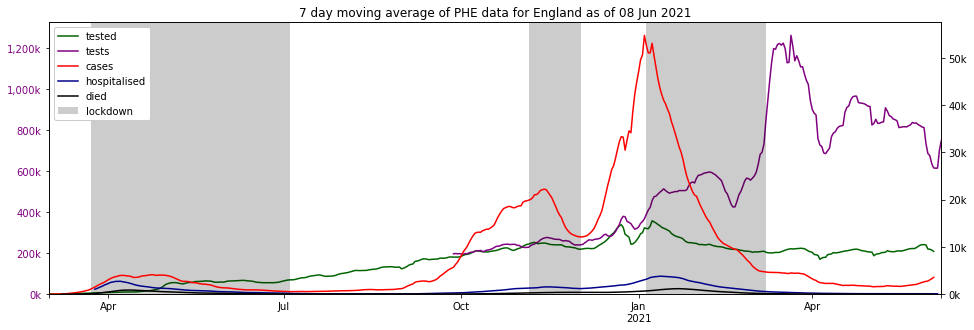

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

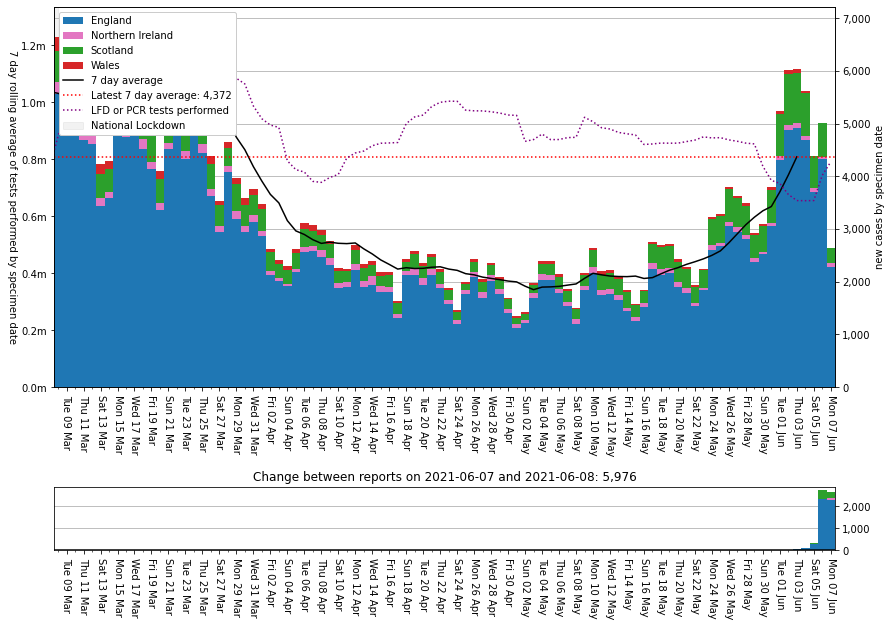

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

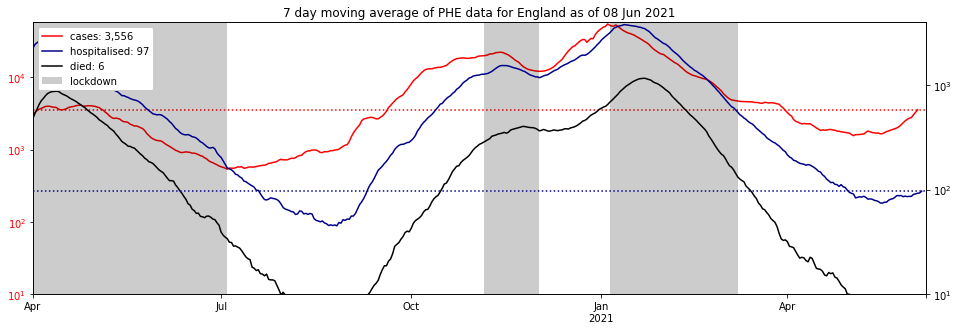

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

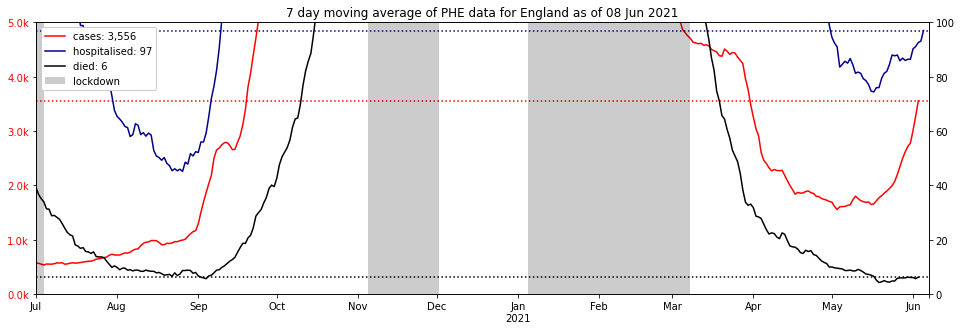

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=5_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,07 Jun 21,"+23,954,753","+33,889,746","+23,954,753","+244,107","+89,639","+244,107"
Northern Ireland,07 Jun 21,"+719,800","+1,094,478","+719,800","+9,679","+3,785","+9,679"
Scotland,07 Jun 21,"+2,282,203","+3,403,866","+2,282,203","+30,944","+17,545","+30,944"
Wales,07 Jun 21,"+1,270,606","+2,185,427","+1,270,606","+21,338","+1,972","+21,338"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,23954753.0,33889746.0,9934993.0,56286961,42.558263,17.650612,39.791125
1,Northern Ireland,N92000002,719800.0,1094478.0,374678.0,1893667,38.010907,19.785844,42.203249
2,Scotland,S92000003,2282203.0,3403866.0,1121663.0,5463300,41.773342,20.530870,37.695788
3,Wales,W92000004,1270606.0,2185427.0,914821.0,3152879,40.299866,29.015417,30.684717


'partial: 40,573,517 (60.7%), full: 28,227,362'

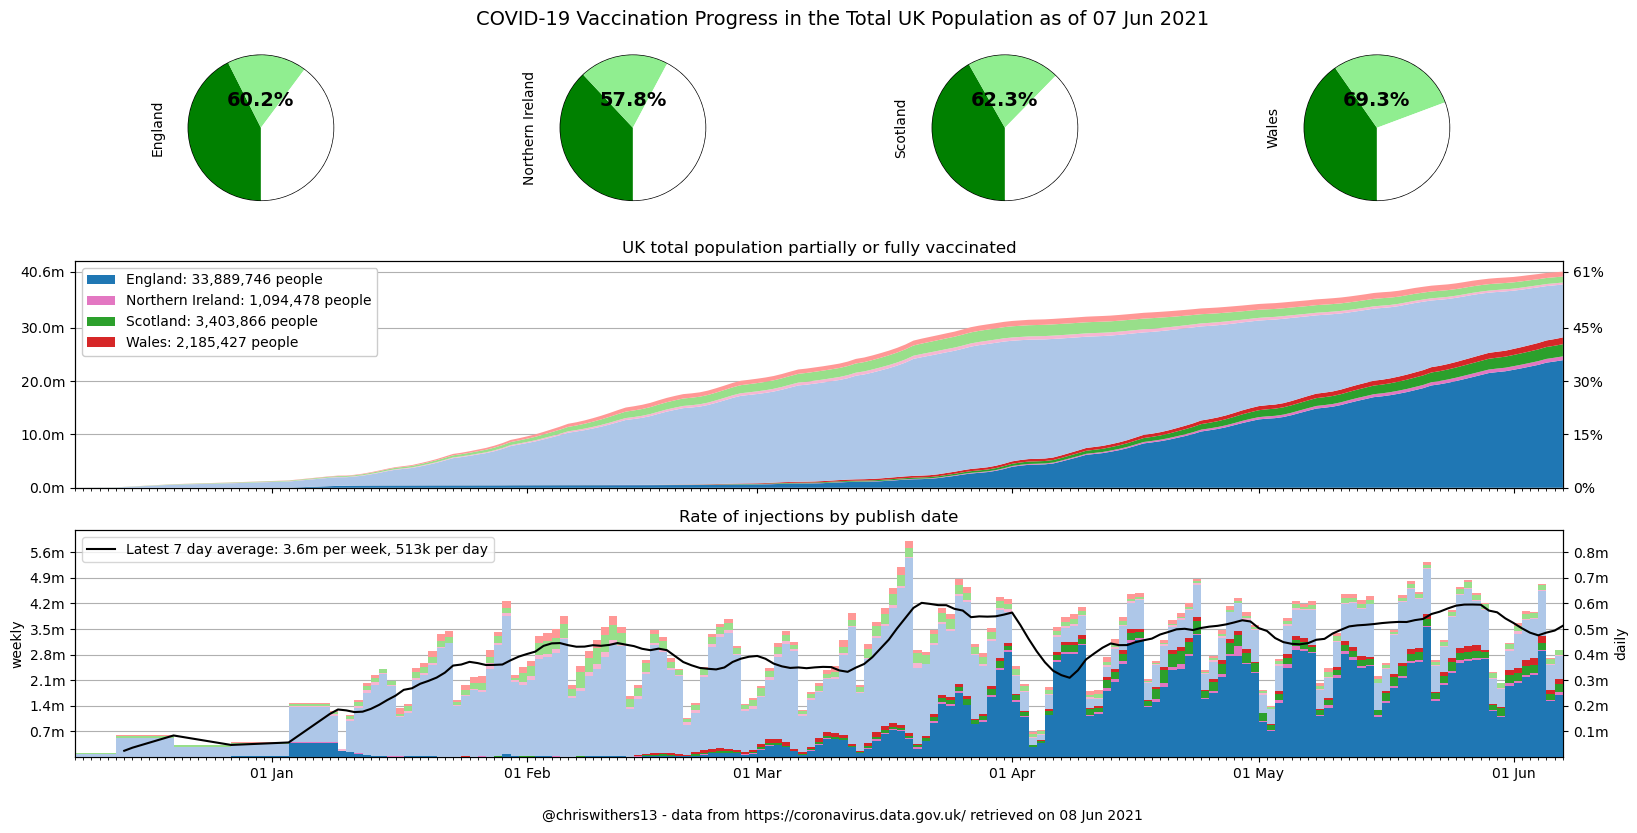

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

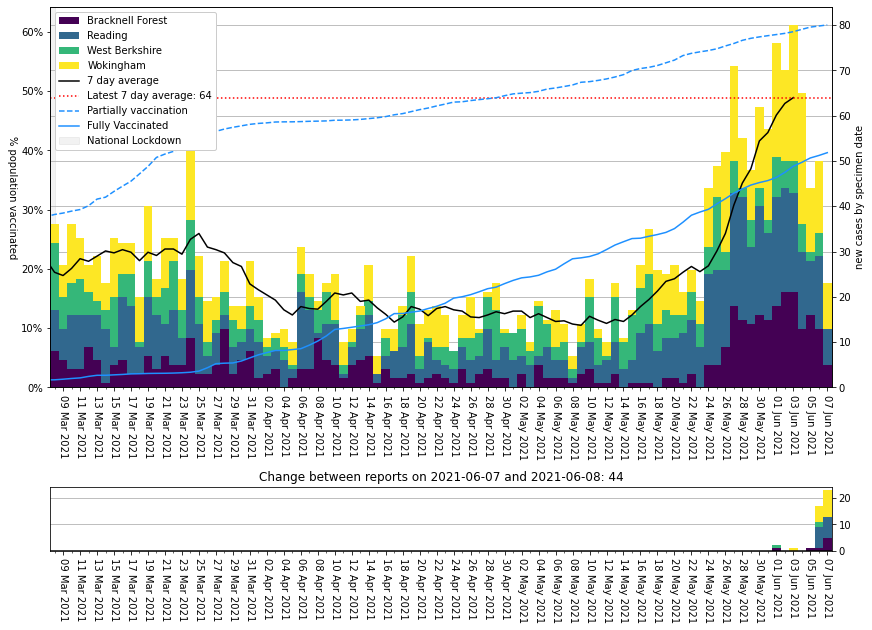

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1],  lines=population_vaccinated)

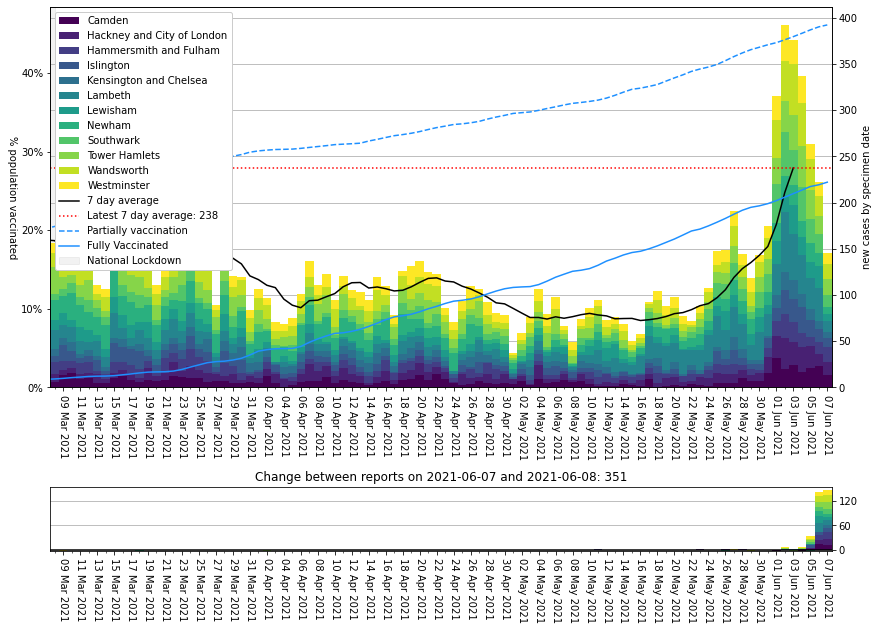

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,576.501710,863.0,2021-06-07
E07000124,Ribble Valley,298.909473,182.0,2021-06-07
E07000125,Rossendale,297.977113,213.0,2021-06-07
E07000120,Hyndburn,293.671261,238.0,2021-06-07
E07000126,South Ribble,293.353071,325.0,2021-06-07
E07000117,Burnley,275.528565,245.0,2021-06-07
E08000001,Bolton,271.257173,780.0,2021-06-07
E08000006,Salford,253.057944,655.0,2021-06-07
E08000003,Manchester,224.831693,1243.0,2021-06-07


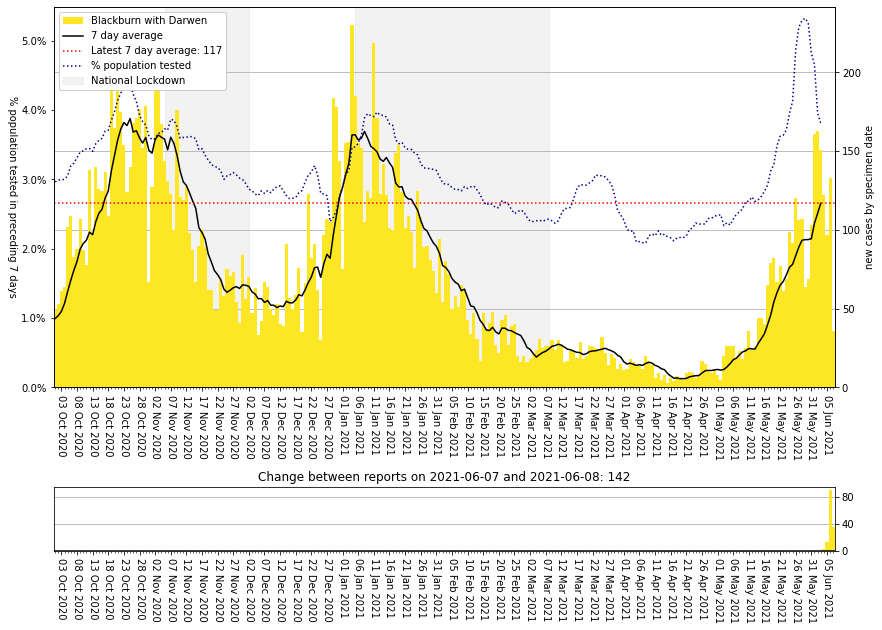

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,224.831693,1243.0,2021-06-07
S12000049,Glasgow City,143.890574,911.0,2021-06-07
E06000008,Blackburn with Darwen,576.501710,863.0,2021-06-07
S12000036,City of Edinburgh,160.783343,844.0,2021-06-07
E08000001,Bolton,271.257173,780.0,2021-06-07
E08000025,Birmingham,64.195983,733.0,2021-06-07
E08000035,Leeds,86.365694,685.0,2021-06-07
E08000006,Salford,253.057944,655.0,2021-06-07
E08000007,Stockport,200.393289,588.0,2021-06-07


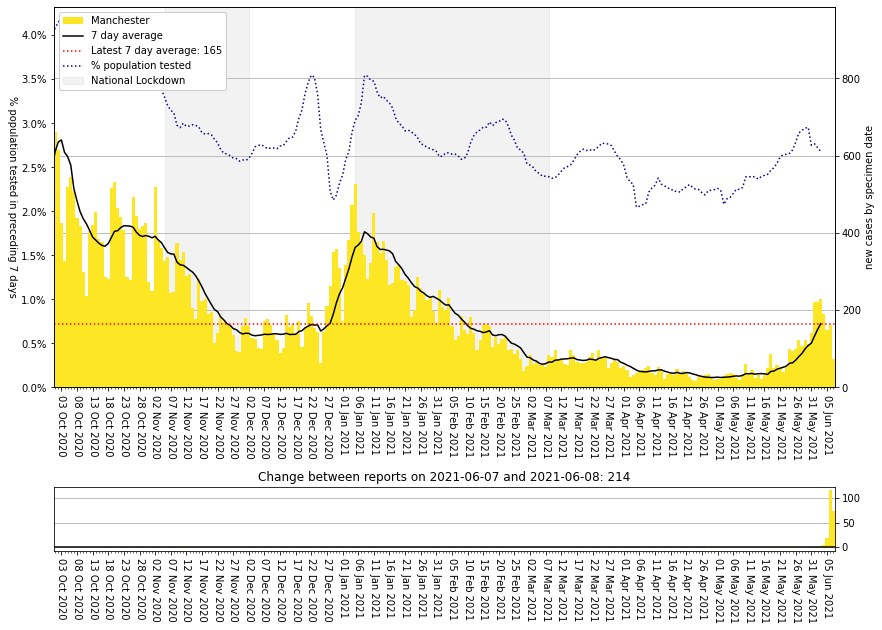

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.4

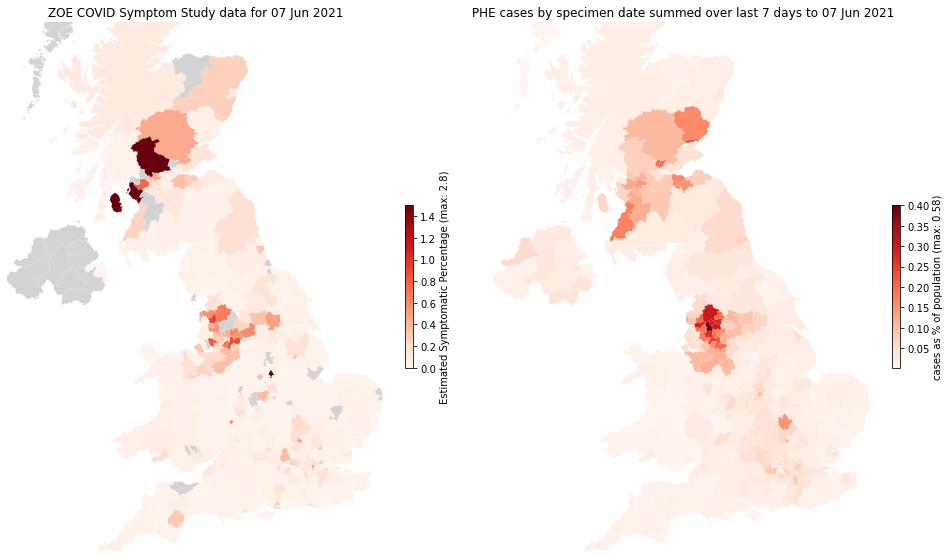

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...